Import the required modules

In [ ]:
"""Import the required modules"""
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [ ]:
def get_table(file, t_var):
    
  # Reads in files.
  df = pd.read_csv(file)
  # Save the target variables.
  t = df[t_var]
  # Drop target variables from df.
  df.drop(t_var, axis=1, inplace=True)
  # Create dummy variables.
  df = pd.get_dummies(df)
  # Join target variables to df
  df = pd.concat([df, t], axis=1)

  return df


In [25]:
file = 'welding_data_by_properties.csv', 'fibre_data.csv'
df = get_table(file[0], ['saw', 'smaw', 'gmaw', 'gtaw']), get_table(file[1], t_var=[])
df[1].head()

,Melt Temperature (0C),Injection Speed (RPM),Injection Pressure (MPa),Cooling Time (Sec),Impact Strength (KJ/m2)
0,180,130,60,10,7.636
1,180,150,70,15,7.939
2,180,170,80,20,8.263
3,180,190,90,25,8.300
4,190,130,70,20,8.224


In [ ]:
# def explore(df, p_start_cols, p_end_cols, t_start_cols, t_end_cols, n_plots, x):
#   pos = 1
#   for i in range(p_start_cols, p_end_cols):
#     print(f'\t{df.columns[i].capitalize()} vs Response values')
#     plt.figure(figsize=[15, 5])
#     for j in range(t_start_cols, t_end_cols+x):
#       plt.subplot(1, n_plots, pos)
#       plt.scatter(df.iloc[:, i], df.iloc[:, j])
#       plt.ylabel(df.columns[j])
#       plt.xlabel(df.columns[i])
#       pos += 1
#     plt.tight_layout()
#     plt.show()
#     print('\n')
#     pos = 1

In [ ]:
# table = ['Welding Data by Properties', 'Welding Data by Welding types']
# for x in range(2):
#     print(table[x])

#     print('\nData Statistical Summary')
#     display(df[x].describe())
#     print('')

#     print('\nExplore data graphically')
#     explore(df[x], 0, 4, 9-x, 13-x, 4+x, x)

In [ ]:
def generate_train_test(df, p_end_col):
  X = df.iloc[:, :p_end_col]
  y = df.iloc[:, p_end_col:]

  return train_test_split(X, y,random_state=1, test_size=0.2)

In [ ]:
generate_train_test(df[0], -4)

In [26]:
def scale_data(X_train, X_test):
    sc_X = StandardScaler()
    X_trainscaled=sc_X.fit_transform(X_train)
    X_testscaled=sc_X.transform(X_test)

    return X_trainscaled, X_testscaled

In [27]:
def ann_analysis():
    X_trainscaled, X_testscaled = scale_data(X_train, X_test)
    reg = MLPRegressor(hidden_layer_sizes=(64, 64, 64), activation='relu', random_state=1, max_iter=5000).fit(X_trainscaled, y_train)

    y_pred=reg.predict(X_testscaled)
    r2 = r2_score(y_pred, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    return r2, rmse, mae, y_pred, reg

In [28]:
def elm_analysis(hidden_size=5000):
  input_size = X_train.shape[1]
  hidden_size = hidden_size
  input_weights = np.random.normal(size=[input_size,hidden_size])
  biases = np.random.normal(size=[hidden_size])

  def relu(x):
    return np.maximum(x, 0, x)

  def hidden_nodes(X):
      G = np.dot(X, input_weights)
      G = G + biases
      H = relu(G)
      return H

  output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

  def predict(X):
      out = hidden_nodes(X)
      out = np.dot(out, output_weights)
      return out

  y_pred = predict(X_test)
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)

  return r2, rmse, mae, y_pred

In [36]:
def disp_matrics(r2, rmse, mae, title):
  print(title)
  print('===============================================')
  print(f'R^2:\t\t{r2}')
  print(f'rmse:\t\t{rmse}')
  print(f'mae:\t\t{mae}')
  print(f'time(s)\t\t{stop - start}')
  print('\n')

In [37]:
def disp_graphs(i, y_test, y_ann_pred, y_elm_pred):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.scatter(y_ann_pred, y_test)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
  plt.title('ANN')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

  plt.subplot(1, 2, 2)
  plt.scatter(y_elm_pred, y_test)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
  plt.title('ELM')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

  plt.suptitle('Comparing Models Predictive Abilities', x=.506, y=1.03, fontsize=16)
  plt.tight_layout()
  plt.show()

In [38]:
def disp_compare_graphs():
  plt.figure(figsize = (10, 5))

  x = np.arange(4)
  ann = [ann_r2*100, ann_rmse, ann_mae, ann_time]
  elm = [elm_r2*100, elm_rmse, elm_mae, elm_time]
  width = 0.40
    
  # plot data in grouped manner of bar type
  plt.bar(x-0.2, ann, width, color='green')
  plt.bar(x+0.2, elm, width, color='red')
  plt.xticks(x, ['R^2', 'RMSE', 'MAE', 'TIME(S)'])
  plt.title("Comparing metrics for ANN and ELM")
  plt.xlabel("Metrics")
  plt.ylabel("Values")
  plt.legend(["ANN", "ELM"])
  plt.show()

MODEL MATRICS.
Testing data:


,Melt Temperature (0C),Injection Speed (RPM),Injection Pressure (MPa),Cooling Time (Sec)
0,180,130,60,10
1,180,150,70,15
2,180,170,80,20
3,180,190,90,25
4,190,130,70,20
5,190,150,60,25
6,190,170,90,10
7,190,190,80,15
8,200,130,80,25
9,200,150,90,20


ANALYSIS OF FIBRE TABLE.
ANN modeling
C:\Users\NNAMDI\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
The ANN model performance for testing set
R^2:		0.8837356454473266
rmse:		150.0590639165469
mae:		109.30604105192957
time(s)		27.6352698802948


ANALYSIS OF FIBRE TABLE.
ELM modeling
The ELM model performance for testing set
R^2:		0.9627079485883707
rmse:		83.69392642649247
mae:		61.99447177214858
time(s)		0.19188809394836426






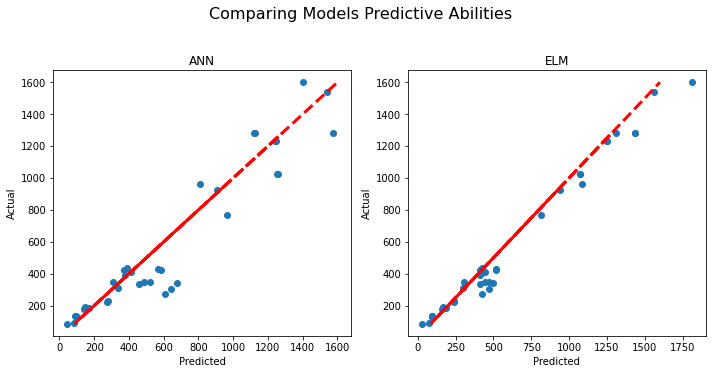

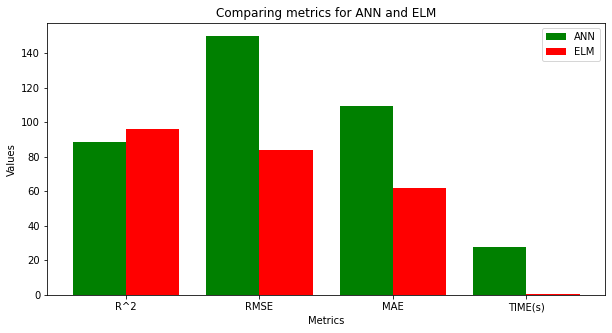

In [39]:
print('MODEL MATRICS.')
print('===============================================')

for i in range(1):
    print('Testing data:')
    display(df[1].iloc[:, :4])
    for model in ['ANN', 'ELM']:
        print(f'ANALYSIS OF FIBRE TABLE.')
        X_train, X_test, y_train, y_test = generate_train_test(df[0], -4)

        if model == 'ANN':
            print('ANN modeling')
            start = time.time()
            ann_r2, ann_rmse, ann_mae, y_ann_pred, reg = ann_analysis()
            stop = time.time()
            ann_time = stop - start

            disp_matrics(ann_r2, ann_rmse, ann_mae, 'The ANN model performance for testing set')
        else:
            print('ELM modeling')
            start = time.time()
            elm_r2, elm_rmse, elm_mae, y_elm_pred = elm_analysis()
            stop = time.time()
            elm_time = stop - start

            # print(f'Predicted values using ELM for {table[i]}')
            # display(y_elm_pred)
            disp_matrics(elm_r2, elm_rmse, elm_mae, 'The ELM model performance for testing set')

    print('\n')

    disp_graphs(i, y_test, y_ann_pred, y_elm_pred)
    disp_compare_graphs()